In [1]:
%load_ext autoreload
%autoreload 2
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
import torch.hub
import torch.nn.functional as F

import glob
from PIL import Image
import numpy as np
import random
import yaml
from addict import Dict
import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import data_utils as utils


## DeepLab PyTorch set-up

In [2]:
model = torch.hub.load("kazuto1011/deeplab-pytorch", "deeplabv2_resnet101", n_classes=182)
config_path = 'deeplab-pytorch/configs/cocostuff164k.yaml'

device = torch.device('cuda')
model.load_state_dict(torch.load("models/deeplabv2_resnet101_msc-cocostuff164k-100000.pth"))
model.eval()
model.to(device)
with open(config_path, 'r') as stream:
    CONFIG = Dict(yaml.load(stream, Loader=yaml.BaseLoader))

Using cache found in /home/bmild/.cache/torch/hub/kazuto1011_deeplab-pytorch_master


In [3]:
def get_classtable(CONFIG):
    with open(CONFIG.DATASET.LABELS) as f:
        classes = {}
        for label in f:
            label = label.rstrip().split("\t")
            classes[int(label[0])] = label[1].split(",")[0]
    return classes

def preprocess_image(image):
    image = utils.crop_blacks(image)
    # Resize
    scale = int(CONFIG.IMAGE.SIZE.TEST) / max(image.shape[:2])
    image = cv.resize(image, dsize=None, fx=scale, fy=scale)
    raw_image = image

    # Subtract mean values
    image = image.astype(np.float32)
    image -= np.array(
        [
            float(CONFIG.IMAGE.MEAN.B),
            float(CONFIG.IMAGE.MEAN.G),
            float(CONFIG.IMAGE.MEAN.R),
        ]
    )

    # Convert to torch.Tensor and add "batch" axis
    image = torch.from_numpy(image.transpose(2, 0, 1)).float().unsqueeze(0)
    image = image.to(device)
    
    return image, raw_image

def inference(model, image):
    _, _, H, W = image.shape

    logits = model(image)
    logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)
    probs = F.softmax(logits, dim=1)[0]
    probs = probs.cpu().numpy()

    # Refine the prob map with CRF
#     if postprocessor and raw_image is not None:
#         probs = postprocessor(raw_image, probs)

    labelmap = np.argmax(probs, axis=0)

    return labelmap

## Example: Choose a frame and preprocess for deeplab

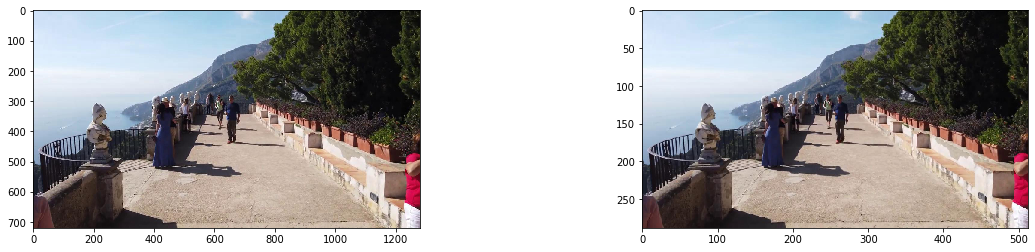

In [5]:
frames = glob.glob('../../frames/*.jpg')
SAMPLE_IMAGE = random.choice(frames)
original_im = np.asarray(Image.open('source2.jpg'))
im, raw_im = preprocess_image(original_im)
plt.figure(figsize=(20,4))
ax = plt.subplot(1,2,1)
ax.imshow(original_im)
ax = plt.subplot(1,2,2)
ax.imshow(raw_im)

In [23]:
classes = get_classtable(CONFIG)
print(classes)
from skimage import color

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'street sign', 12: 'stop sign', 13: 'parking meter', 14: 'bench', 15: 'bird', 16: 'cat', 17: 'dog', 18: 'horse', 19: 'sheep', 20: 'cow', 21: 'elephant', 22: 'bear', 23: 'zebra', 24: 'giraffe', 25: 'hat', 26: 'backpack', 27: 'umbrella', 28: 'shoe', 29: 'eye glasses', 30: 'handbag', 31: 'tie', 32: 'suitcase', 33: 'frisbee', 34: 'skis', 35: 'snowboard', 36: 'sports ball', 37: 'kite', 38: 'baseball bat', 39: 'baseball glove', 40: 'skateboard', 41: 'surfboard', 42: 'tennis racket', 43: 'bottle', 44: 'plate', 45: 'wine glass', 46: 'cup', 47: 'fork', 48: 'knife', 49: 'spoon', 50: 'bowl', 51: 'banana', 52: 'apple', 53: 'sandwich', 54: 'orange', 55: 'broccoli', 56: 'carrot', 57: 'hot dog', 58: 'pizza', 59: 'donut', 60: 'cake', 61: 'chair', 62: 'couch', 63: 'potted plant', 64: 'bed', 65: 'mirror', 66: 'dining table', 67: 'window', 68: 'des

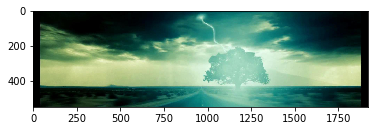

(1054080, 3)
(549, 1920)
[[-2.06658218e+00  1.75383571e-03  1.82608860e-01]
 [-5.33586176e+00 -1.77859638e-01  3.01813059e-01]
 [ 2.49666708e-01 -3.15745936e-01 -5.38157555e-01]]


/home/bmild/anaconda2/envs/comp-color/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/bmild/anaconda2/envs/comp-color/lib/python3.7/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 24907 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


ValueError: assignment destination is read-only

In [34]:
torch.set_grad_enabled(False)
original_im = np.asarray(Image.open('source2.jpg'))
original_im2 = np.asarray(Image.open('target2.jpg'))
plt.imshow(original_im2)
plt.show()
im, raw_im = preprocess_image(original_im)
im2, raw_im2 = preprocess_image(original_im2)


class_list = list(classes.keys())
labelmap = inference(model, im)
labelmap2 = inference(model, im2)

labelmap = np.asarray(Image.open('source2_mask.jpg'))[:,:,0]
labelmap2 = np.asarray(Image.open('target2_mask.jpg'))[:,:,0]


labels, counts = np.unique(labelmap, return_counts=True)
count_dict = dict(zip(labels,counts))
labels2, counts2 = np.unique(labelmap2, return_counts=True)
count_dict2 = dict(zip(labels2,counts2))
img2_res = original_im2.reshape((-1,3))
for target_label in np.unique(labelmap):
    if count_dict.get(target_label) is not None and count_dict[target_label] > 20:
        if count_dict2.get(target_label) is not None and count_dict2[target_label] > 20:
            img_lab = color.rgb2lab(original_im)
            img2_lab = color.rgb2lab(original_im2)

            img_down_rs = np.reshape(img_lab, (-1,3))
            mask = labelmap == target_label
            mask_rs = mask.flatten()

            img2_down_rs = np.reshape(img2_lab, (-1,3))
            print(img2_down_rs.shape)
            print(labelmap2.shape)
            mask2 = labelmap2 == target_label
            mask2_rs = mask2.flatten()

            img_pts = random.sample(list(np.where(mask_rs)[0]), 20)
            img2_pts = random.sample(list(np.where(mask2_rs)[0]), 20)

            transfer = np.linalg.lstsq(img2_down_rs[img2_pts], img_down_rs[img_pts])[0]
            print(transfer)
#             img2_idx, color_max2 = index_image(img2, color_model, color_terms, count_table)
#             mask2 = search(img2_idx, color_idx, count_table, color_max2, len(color_terms), thresh=20)

            mask_floats = mask2.astype(np.float32)
            mask_floats = cv.GaussianBlur(mask_floats, (21, 21), 0)    

            img2_pts = np.where(mask_floats.flatten() > 0)[0]



            x = color.rgb2lab(original_im2).reshape((-1,3))[img2_pts].dot(transfer)
            img2_transfer = np.dot(color.rgb2lab(original_im2).reshape((-1,3))[img2_pts], transfer)
            img2_transfer = color.lab2rgb(img2_transfer.reshape((1,-1,3)))
            img2_transfer = img2_transfer.reshape((-1,3))

            mask_floats = np.repeat(mask_floats[:,:,np.newaxis], 3, axis=2)
            img2_res[img2_pts] = img2_res[img2_pts]*(1 - .5*mask_floats.reshape((-1,3))[img2_pts]) + (img2_transfer * 255).astype(np.uint8)*(.5*mask_floats.reshape((-1,3))[img2_pts])


            img2_transfered = img2_res.reshape(img2.shape)
            plt.imshow(img2_transfered)
            plt.show()



plt.figure(figsize=(24,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Input image")
ax.imshow(raw_im2)
ax.axis("off")
mask2 = labelmap2 == target_label
ax = plt.subplot(1, 2, 2)
ax.imshow(raw_im2[...])
ax.imshow(mask2.astype(np.float32), alpha=0.5)
ax.axis("off")


plt.tight_layout()
plt.show()

print(labels2)

## Example: Sample many frames and display histogram of a particular label

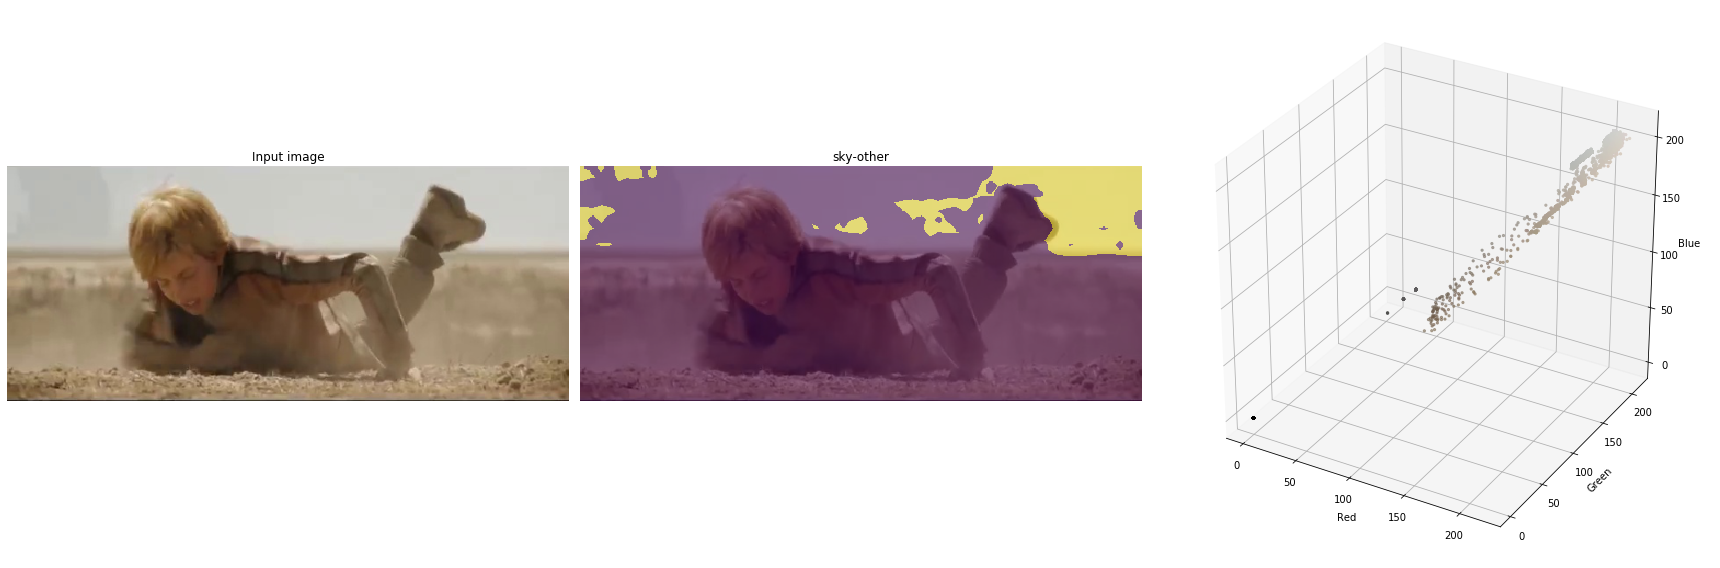

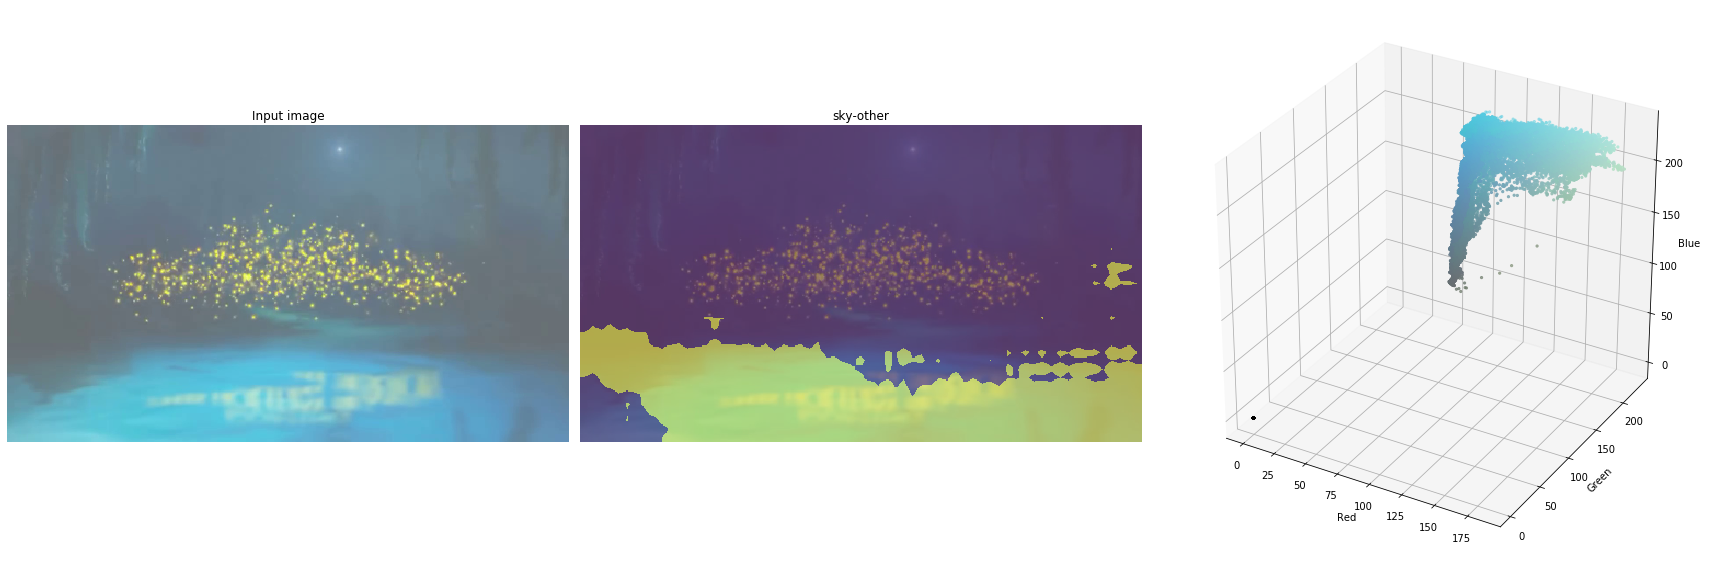

pass


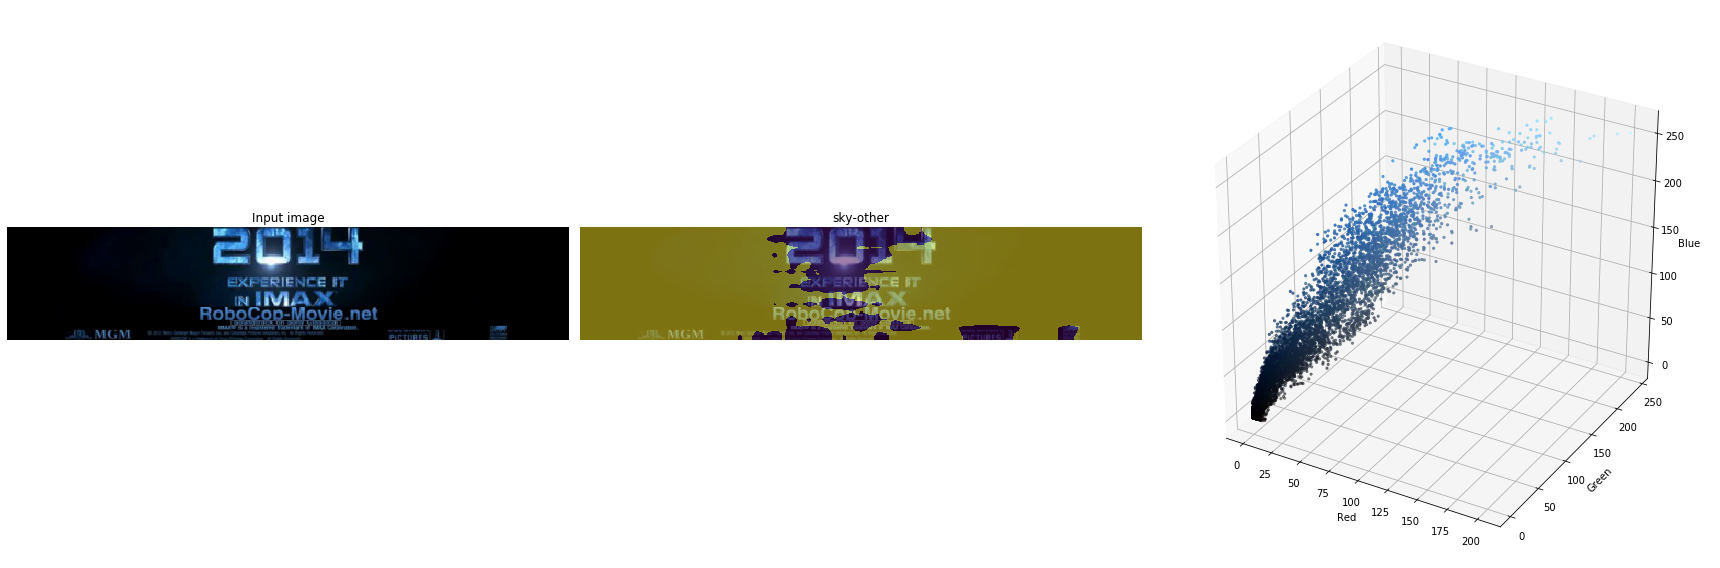

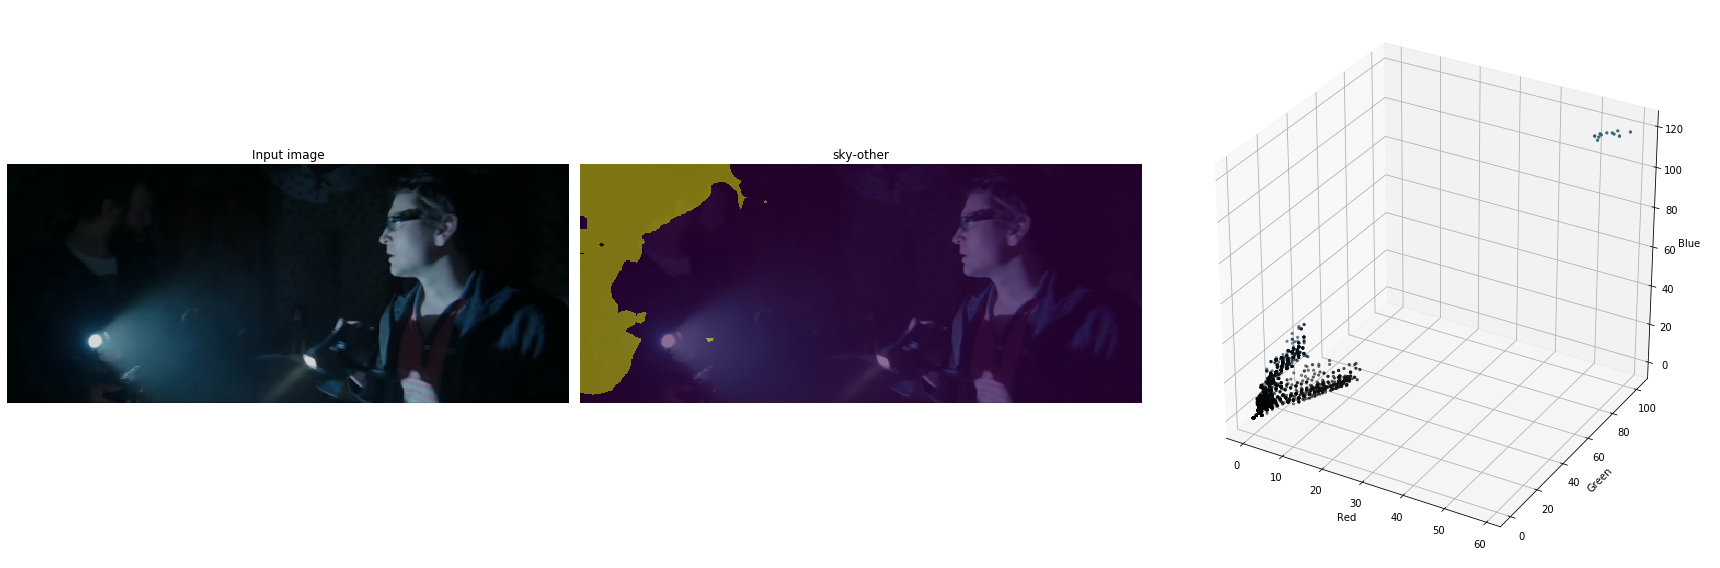

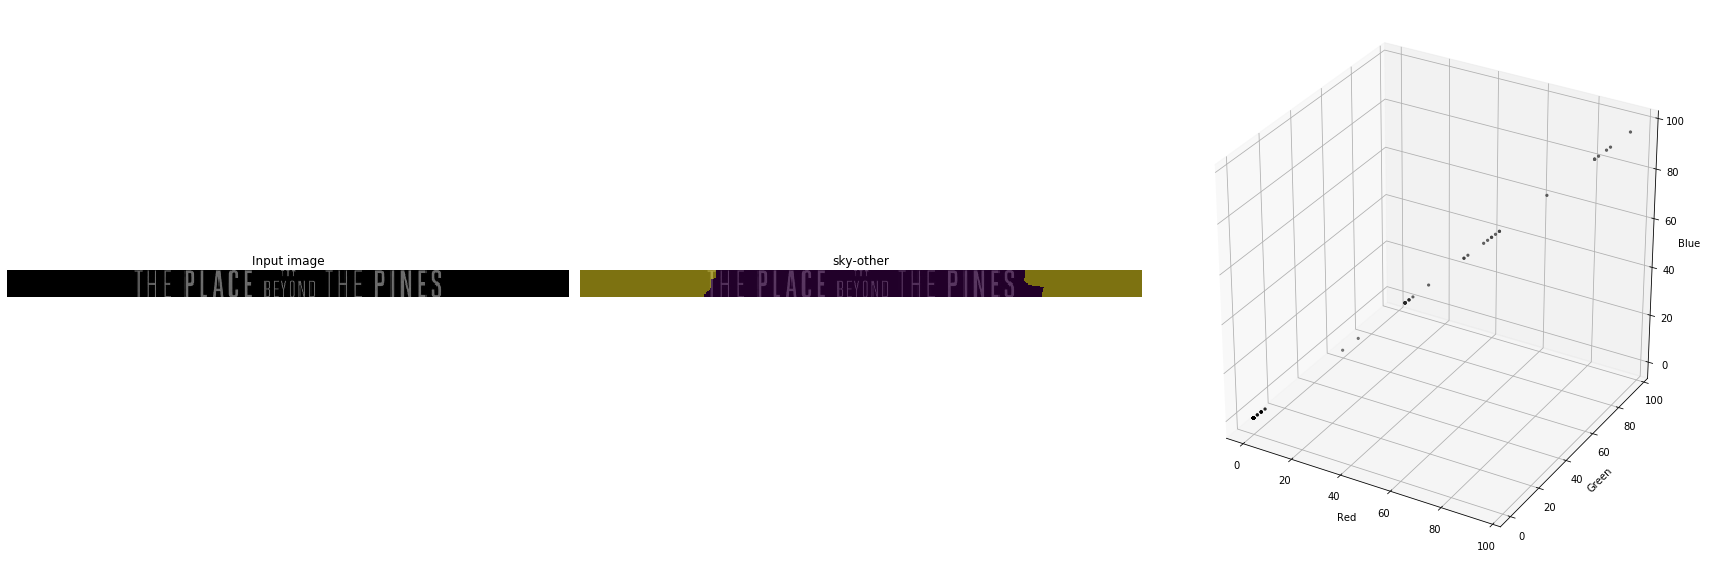

pass


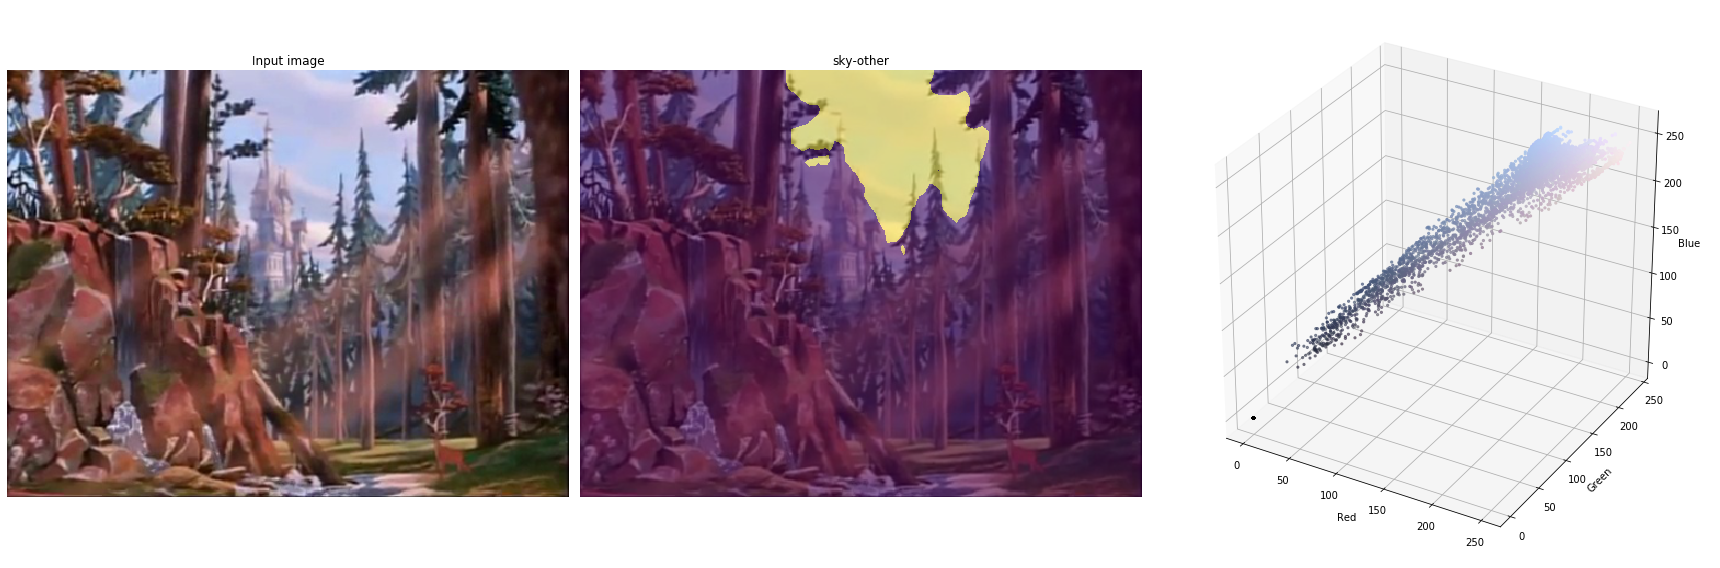

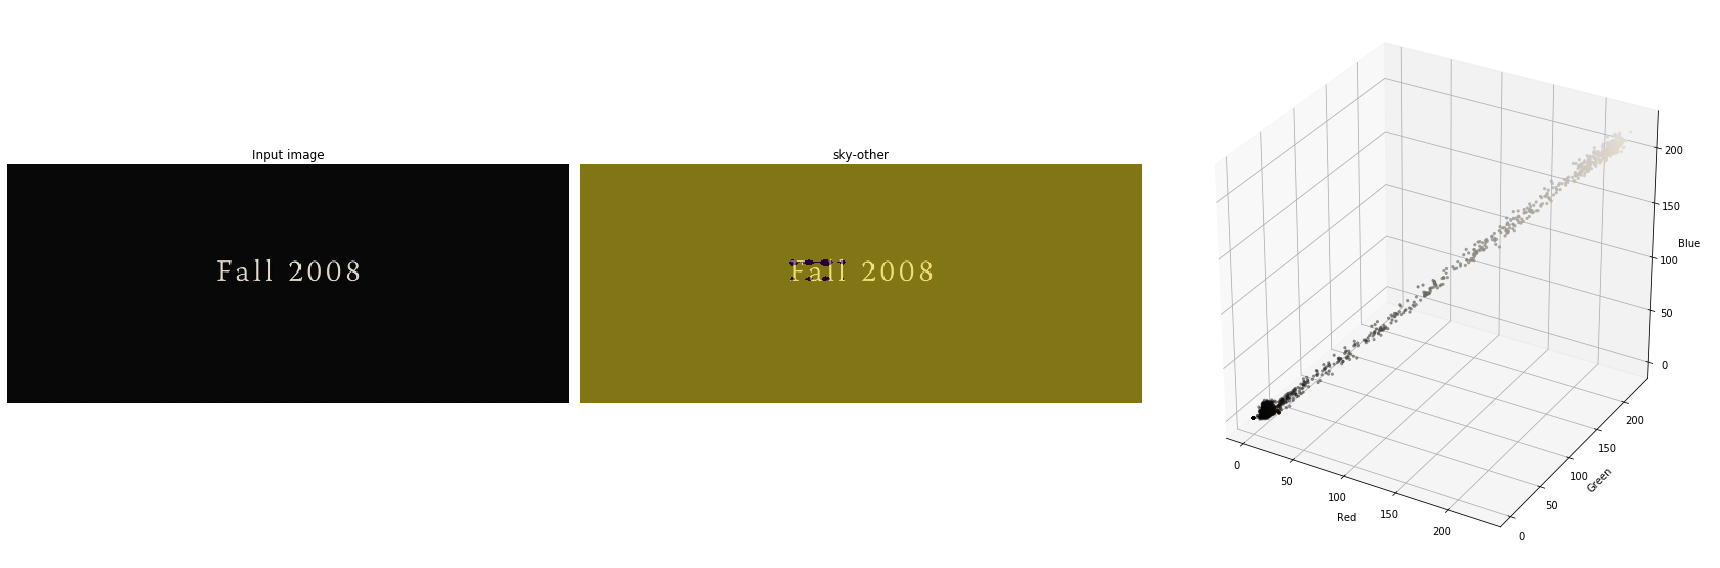

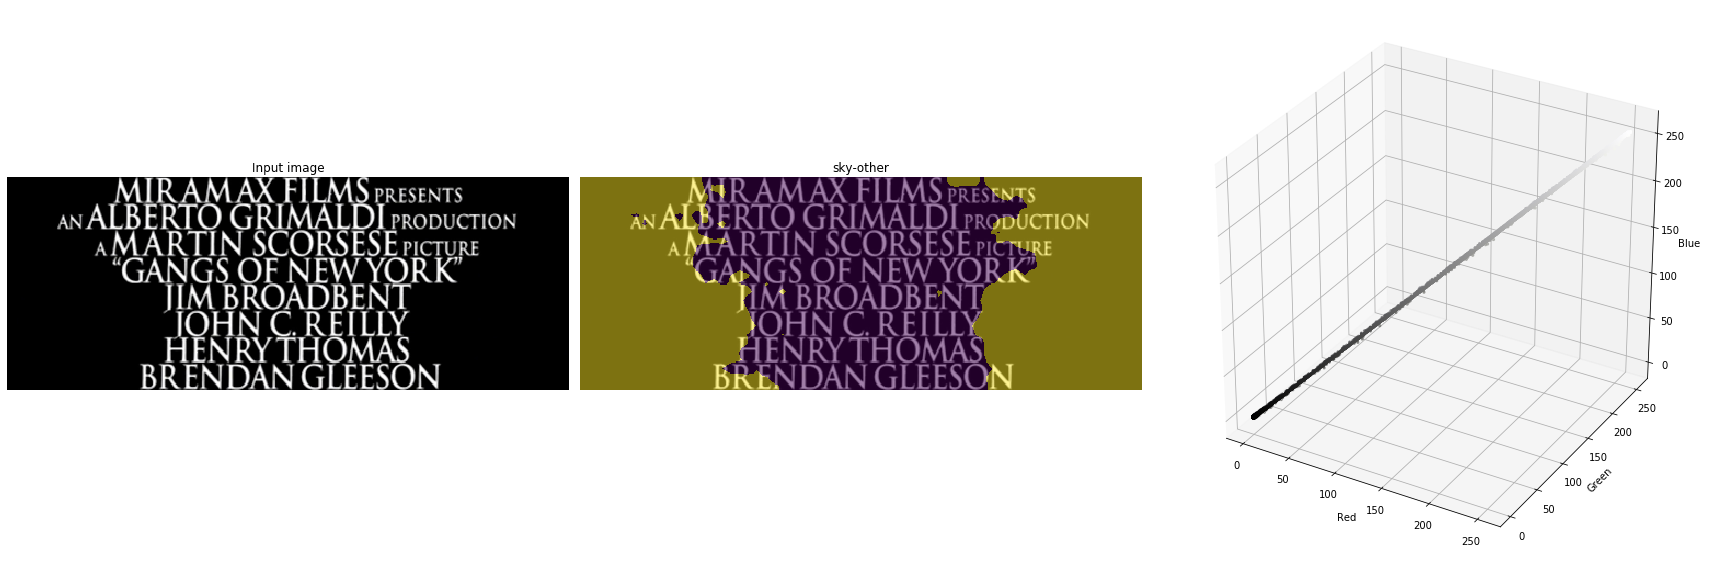

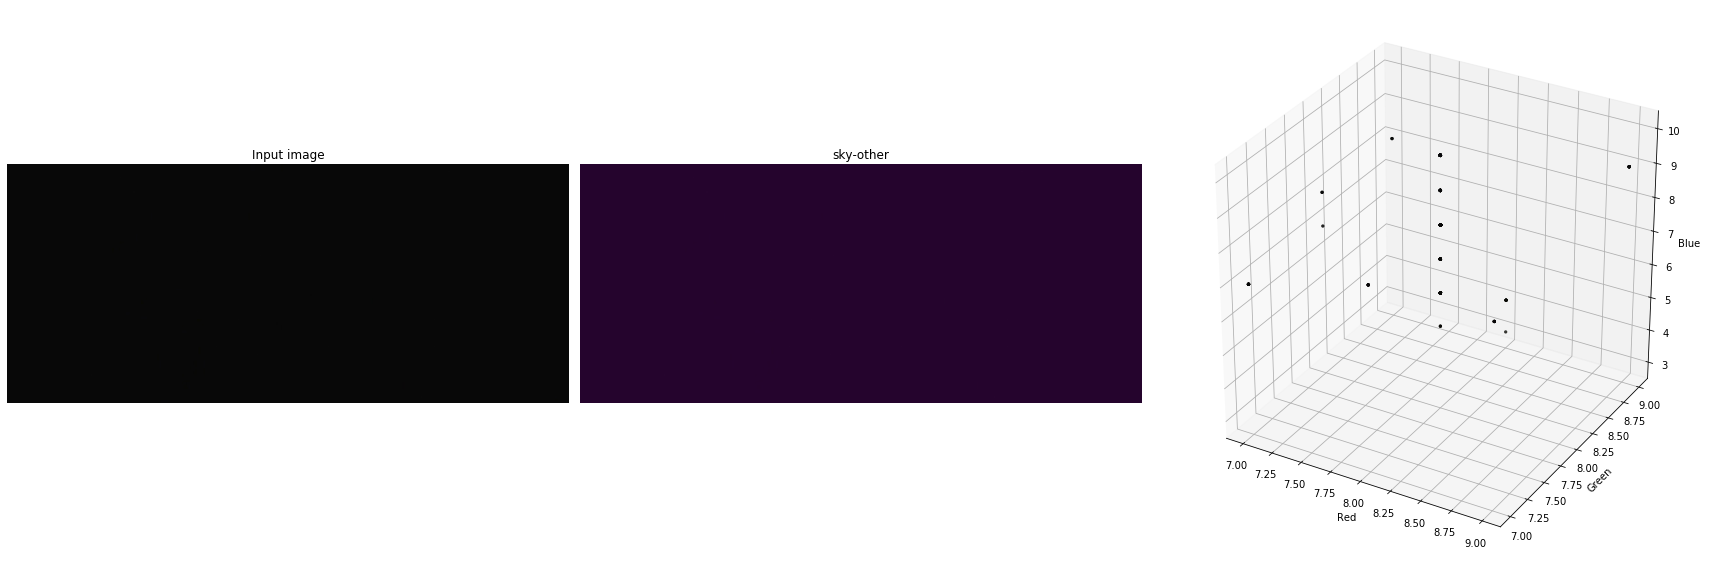

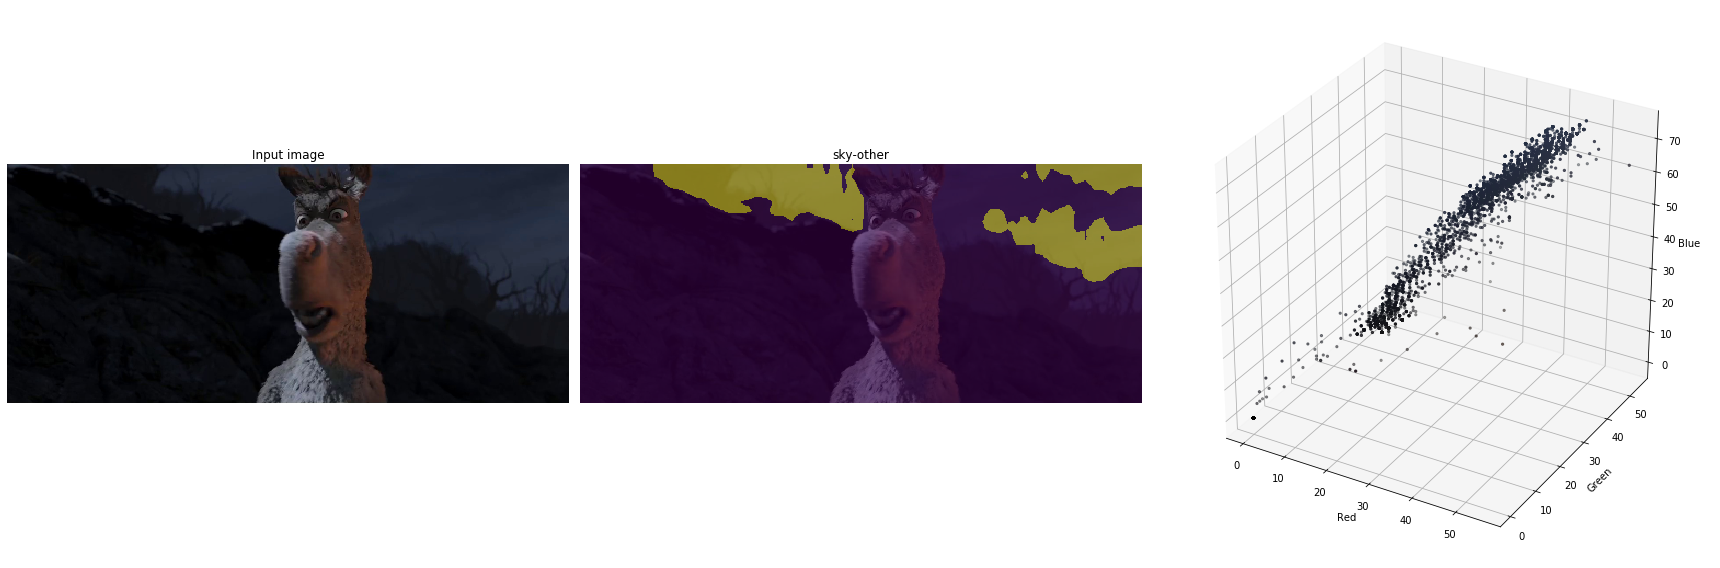

pass


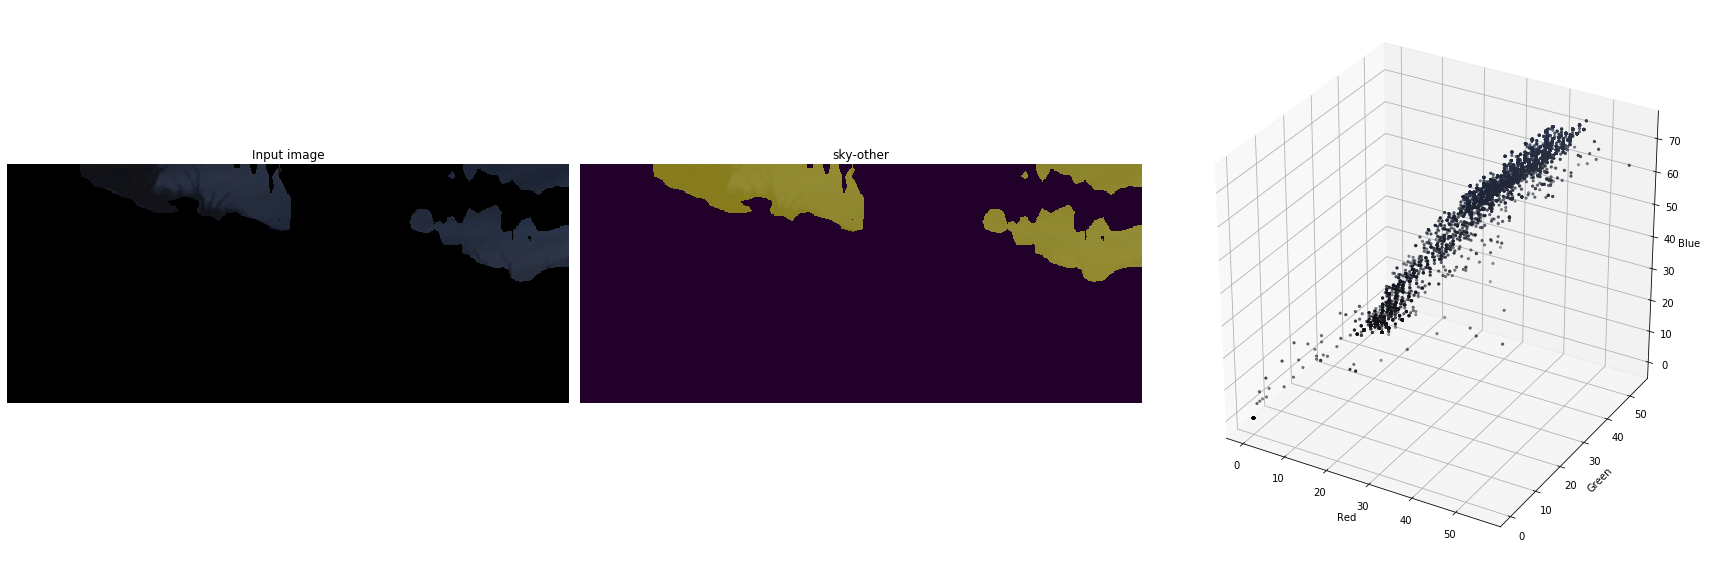

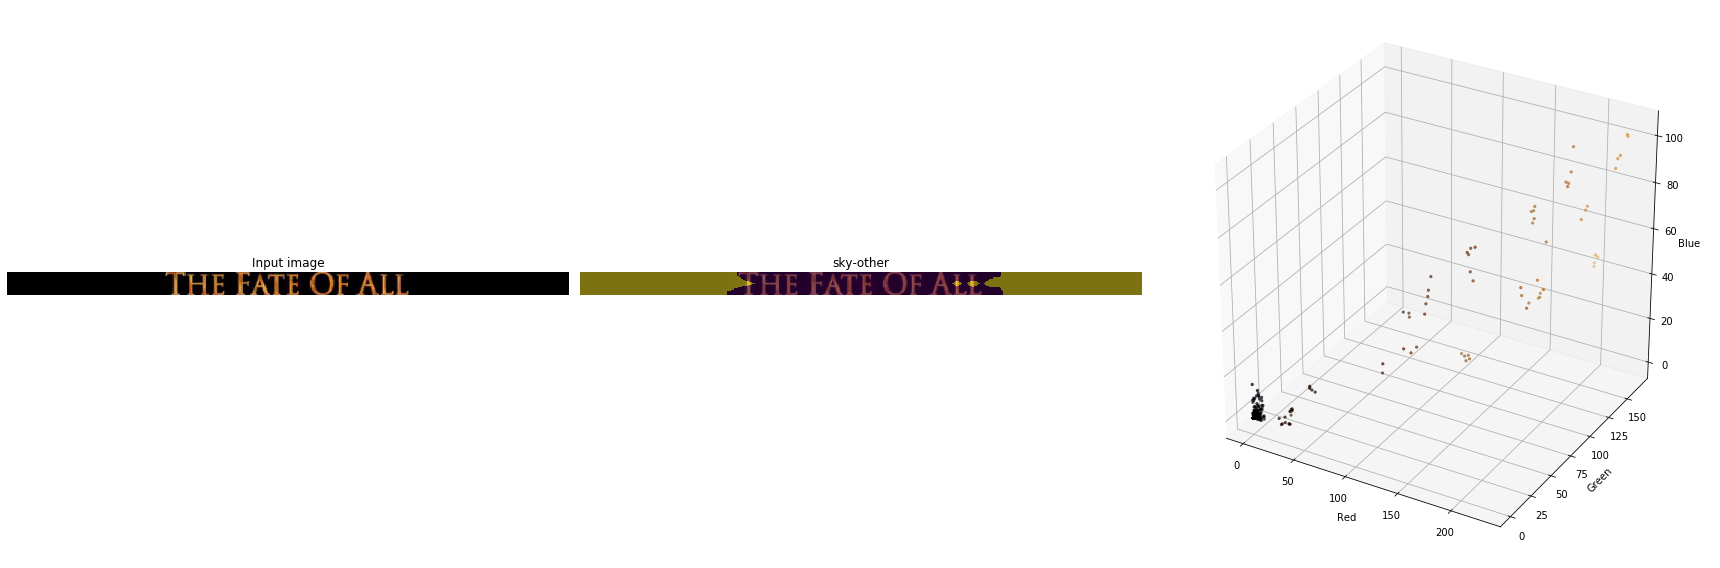

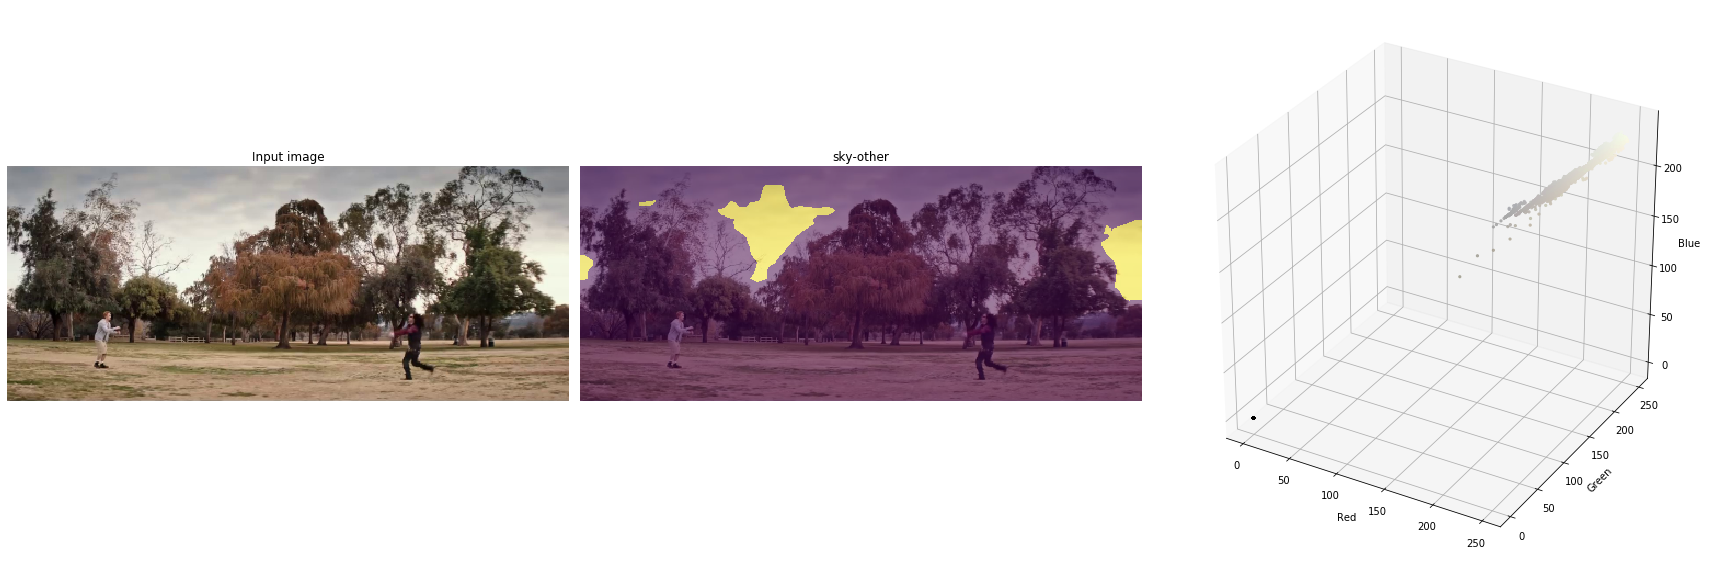

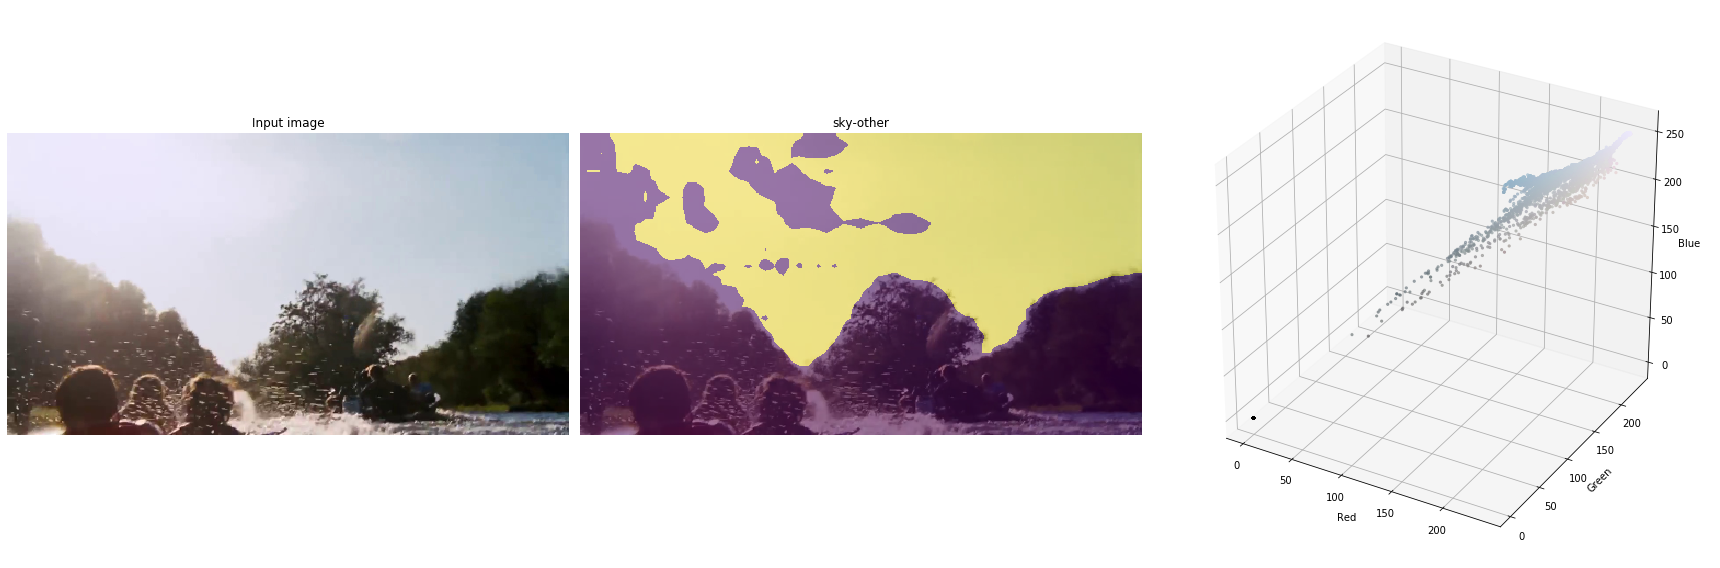

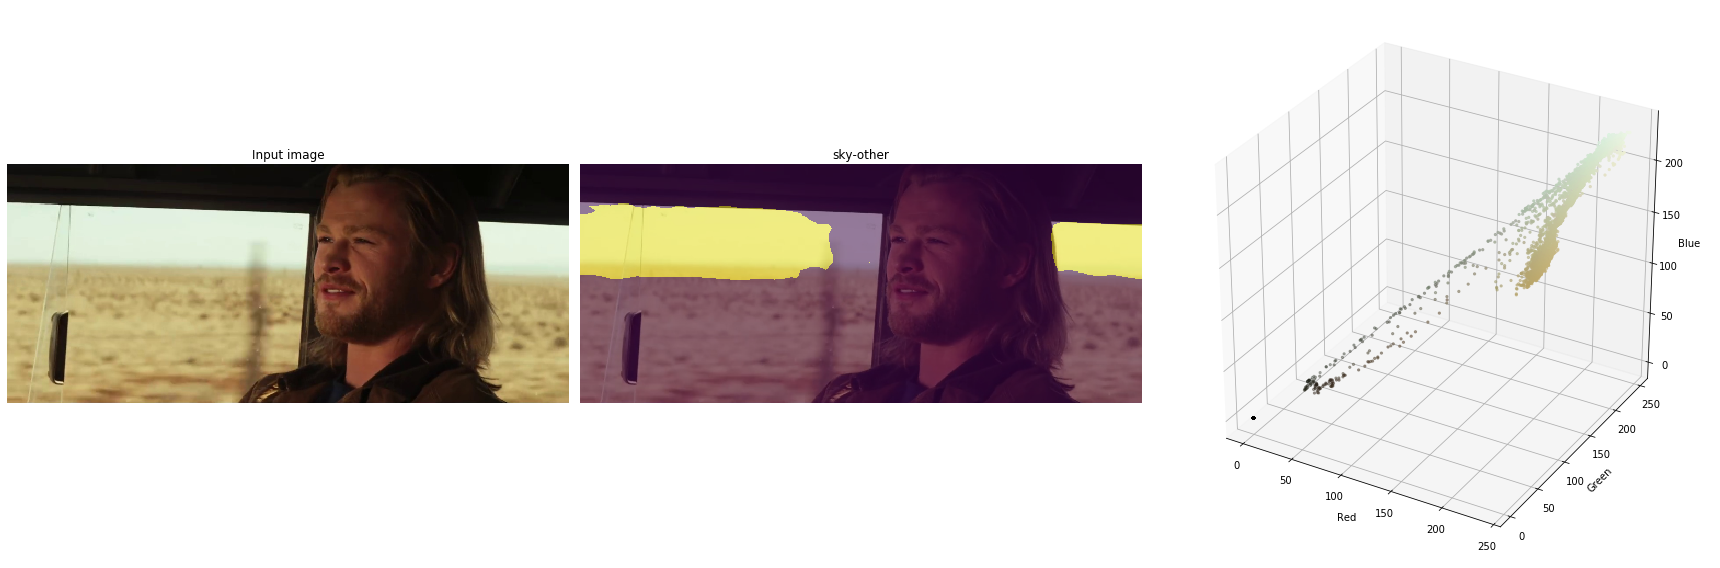

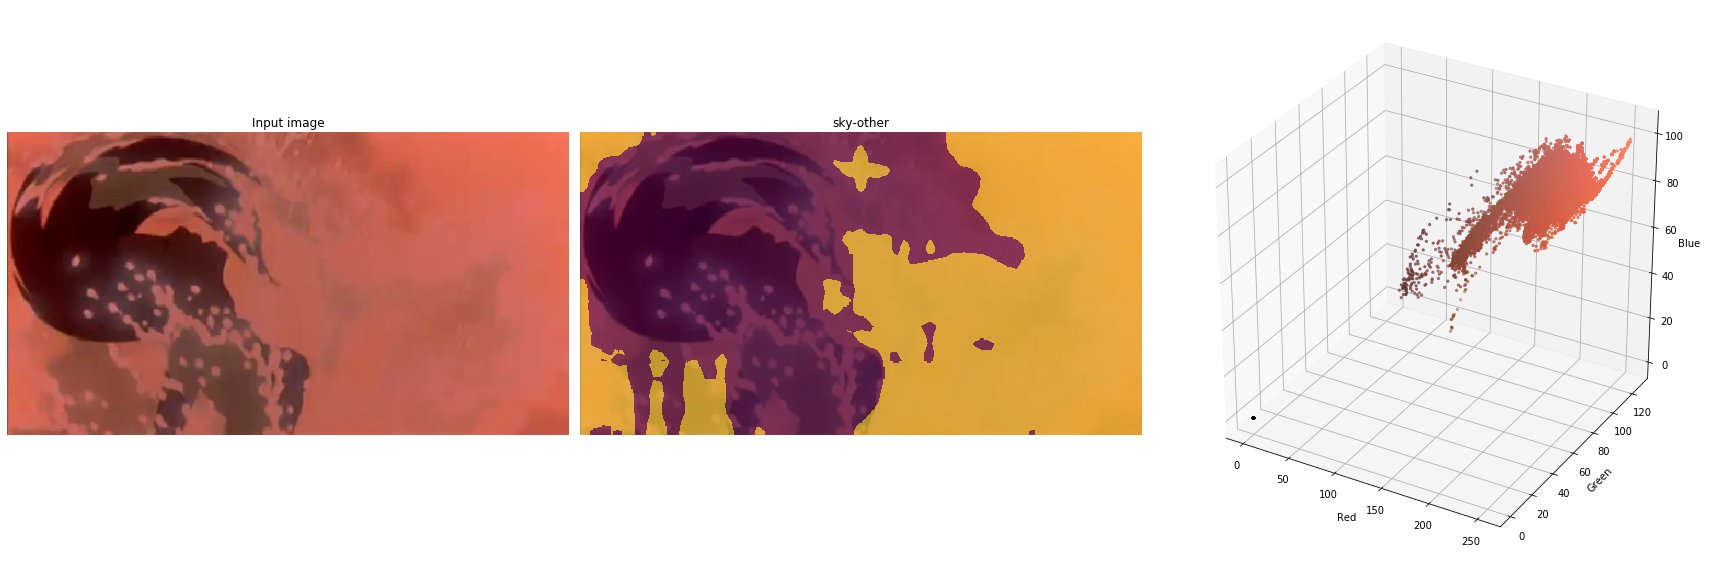

pass


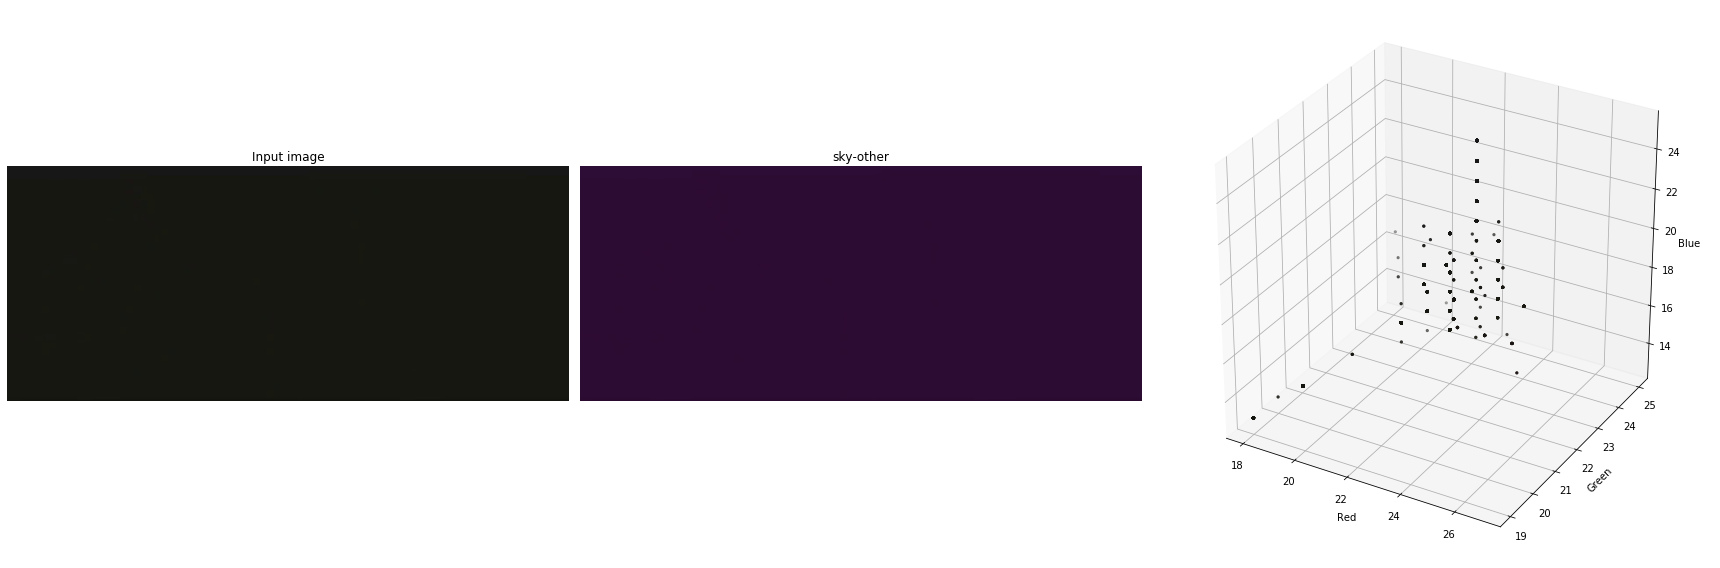

pass


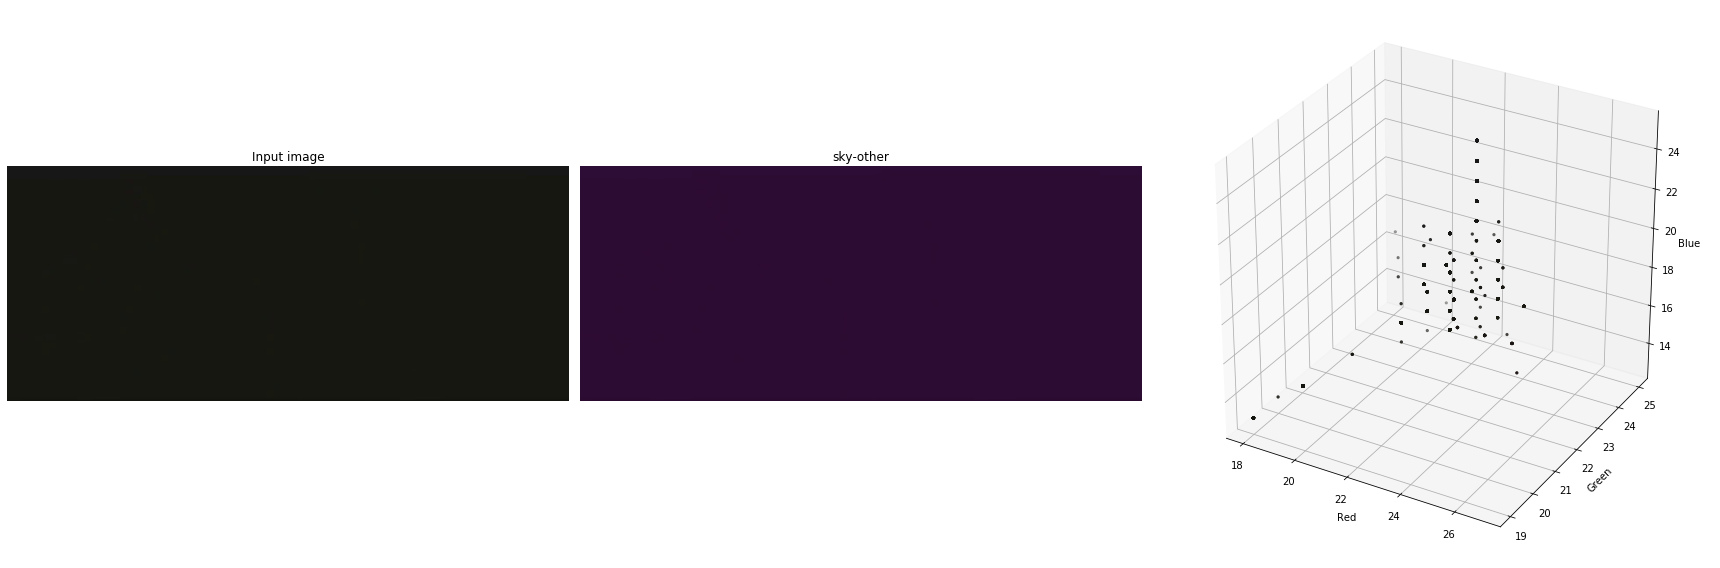

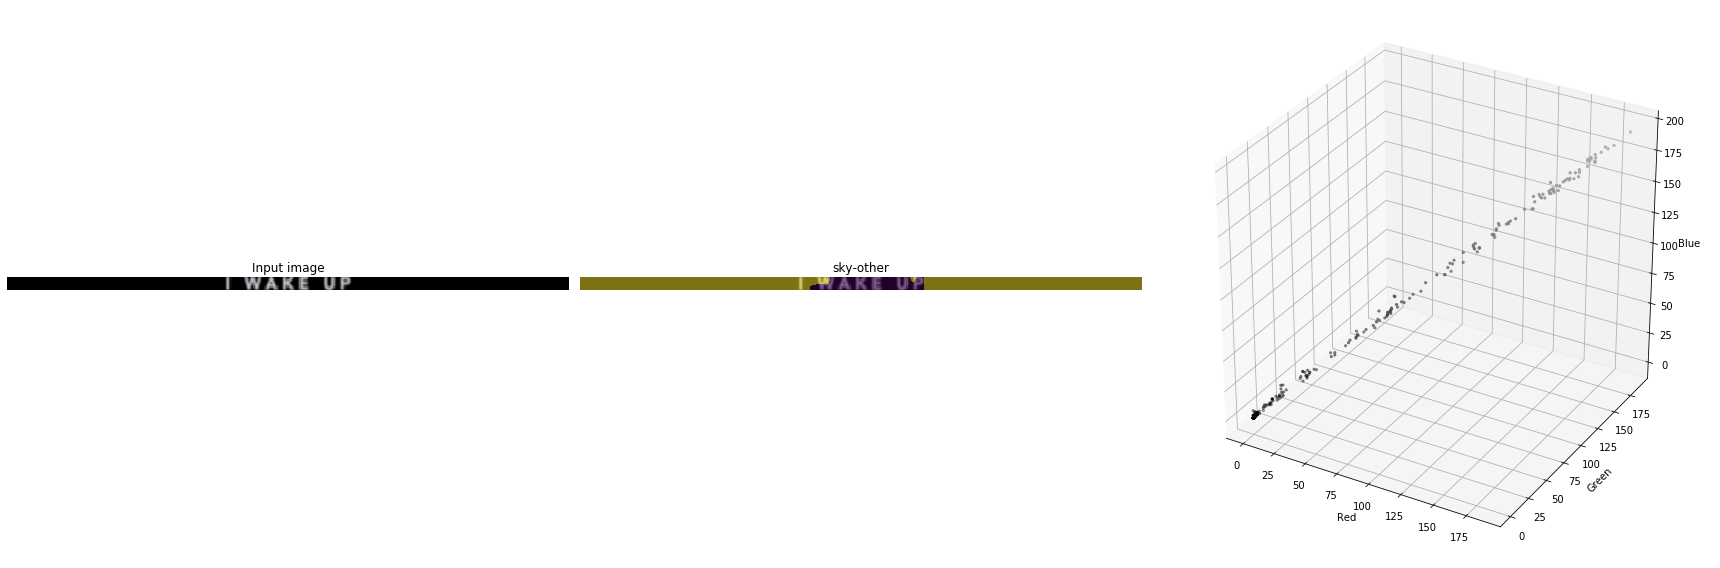

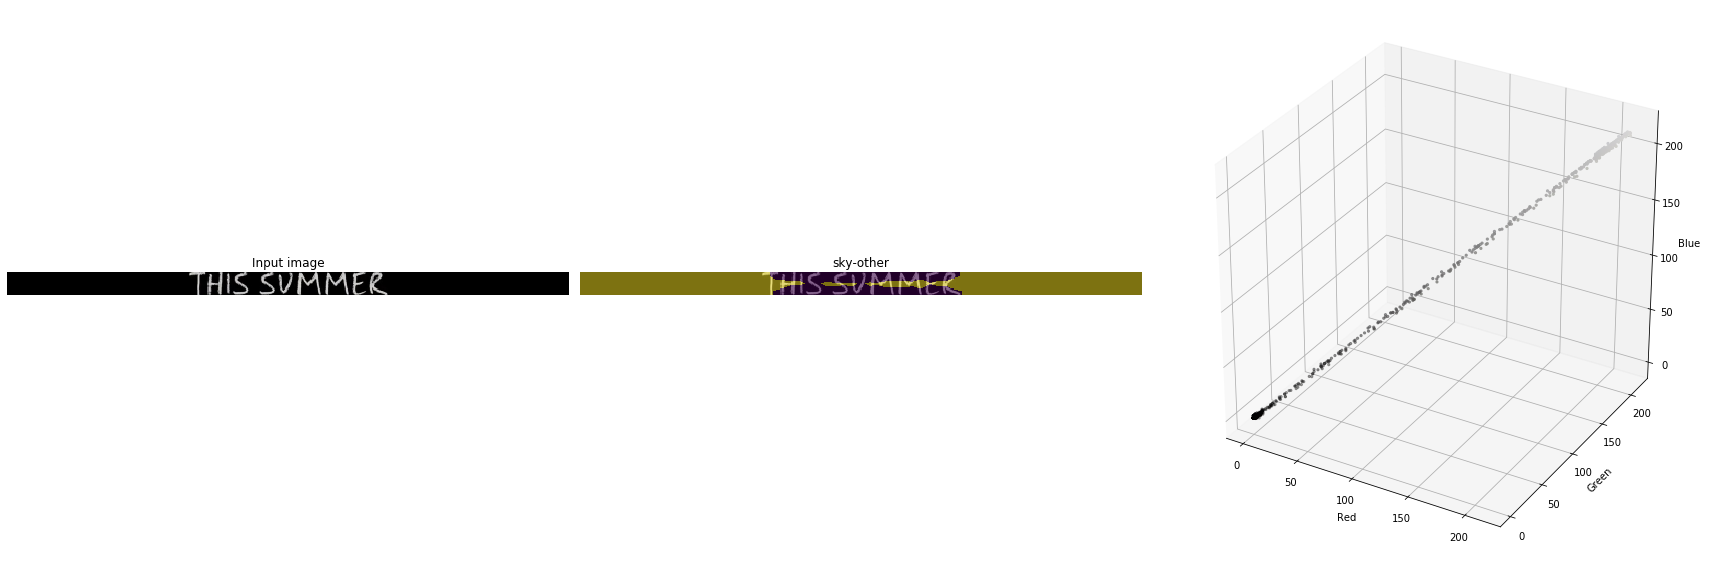

In [22]:
torch.set_grad_enabled(False)

classes = get_classtable(CONFIG)
# print(classes)
frames = glob.glob('../../frames/*.jpg')
# label = np.where(LABEL_NAMES=='sky')[0][0]
# print(label)
target_label = 156
for i in range(100):
    SAMPLE_IMAGE = random.choice(frames)
    original_im = np.asarray(Image.open(SAMPLE_IMAGE))
    try:
        im, raw_im = preprocess_image(original_im)
    except:
        print("pass")
    labelmap = inference(model, im)
    # print(labelmap)

    labels, counts = np.unique(labelmap, return_counts=True)
    count_dict = dict(zip(labels,counts))
    if count_dict.get(target_label) is not None and count_dict[target_label] > im.shape[2] * im.shape[3] * .05:
        plt.figure(figsize=(24,8))
        ax = plt.subplot(1, 3, 1)
        ax.set_title("Input image")
        ax.imshow(raw_im)
        ax.axis("off")
        mask = labelmap == target_label
        ax = plt.subplot(1, 3, 2)
        ax.set_title(classes[target_label])
        ax.imshow(raw_im[...])
        ax.imshow(mask.astype(np.float32), alpha=0.5)
        ax.axis("off")
        ax = plt.subplot(1, 3, 3, projection="3d")
        idx=(mask==0)
        masked_im = raw_im
        masked_im[idx] = 0
        ax = utils.get_3d_dist(masked_im, ax)

        plt.tight_layout()
        plt.show()

## Example: Histogram matching by RGB

../../frames/EI_3ywJLQio_1100.jpg


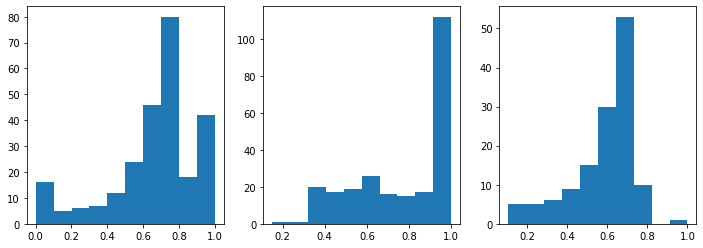

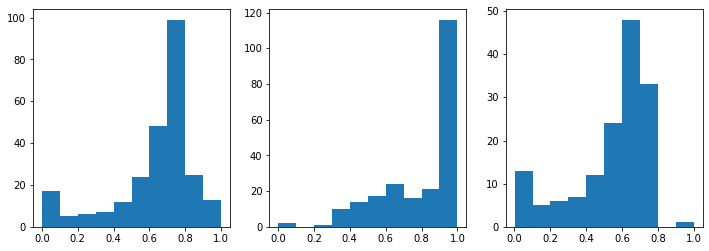

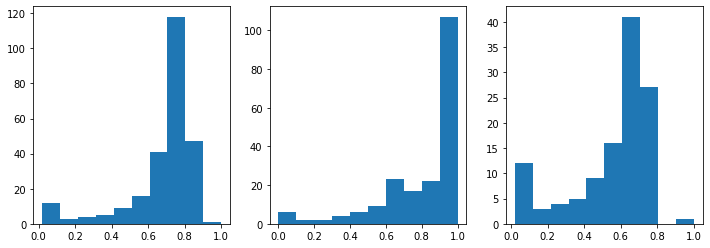

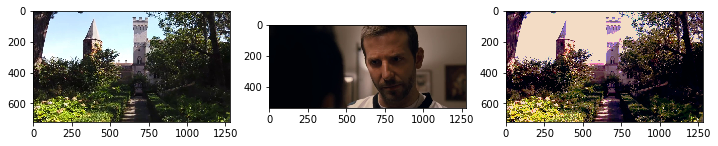

In [20]:
casual_frames = glob.glob('../casual_frames/*.jpg')
frames = glob.glob('../../frames/*.jpg')
trg_file = random.choice(frames)
target = utils.crop_blacks(np.asarray(Image.open(trg_file)))
src_file = random.choice(casual_frames)
source = np.asarray(Image.open(src_file))
print(trg_file)
new_r = utils.hist_match(source[:,:,0], target[:,:,0], plot=True)
new_g = utils.hist_match(source[:,:,1], target[:,:,1], plot=True)
new_b = utils.hist_match(source[:,:,2], target[:,:,2], plot=True)
new_im = (np.dstack([new_r, new_g, new_b]) / 255).reshape(source.shape)

plt.figure(figsize=(12,4))
ax = plt.subplot(1,3,1)
ax.imshow(source)
ax = plt.subplot(1,3,2)
ax.imshow(target)
ax = plt.subplot(1,3,3)
ax.imshow(new_im)
plt.show()

## Example: Accumulate colors (with user validation) and display as 3D Histogram

In [21]:
torch.set_grad_enabled(False)

classes = get_classtable(CONFIG)
print(classes)
frames = glob.glob('../clustering/Action/*.jpg')

quantize = True
n = 32

target_label = 156
all_colors = None

for i in range(50):
    SAMPLE_IMAGE = random.choice(frames)
    original_im = np.asarray(Image.open(SAMPLE_IMAGE))
    try:
        im, raw_im = preprocess_image(original_im)
    except:
        print("pass")
    labelmap = inference(model, im)
    # print(labelmap)

    labels, counts = np.unique(labelmap, return_counts=True)
    count_dict = dict(zip(labels,counts))
    if count_dict.get(target_label) is not None and count_dict[target_label] > im.shape[2] * im.shape[3] * .05:

        mask = labelmap == target_label
        idx=(mask!=0)
        if quantize:
            masked_im = raw_im.quantize(n, method=1, kmeans=5)[idx].reshape((1,-1,3))
        else:
            masked_im = raw_im[idx].reshape((1,-1,3))
        masked_im = raw_im[idx].reshape((1,-1, 3))
        plt.figure(figsize=(24,8))
        ax = plt.subplot(1, 3, 1)
        ax.set_title("Input image")
        ax.imshow(raw_im)
        ax.axis("off")
        ax = plt.subplot(1, 3, 2)
        ax.set_title(classes[target_label])
        ax.imshow(raw_im[...])
        ax.imshow(mask.astype(np.float32), alpha=0.5)
        ax.axis("off")
        ax = plt.subplot(1, 3, 3, projection="3d")
        ax = get_3d_dist(masked_im, ax)
        plt.tight_layout()
        plt.show()
        
        include = input("Include?")
        if include=='y':
            if all_colors is None:
                all_colors = masked_im
            else:
                all_colors = np.concatenate((all_colors, masked_im), axis=1)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'street sign', 12: 'stop sign', 13: 'parking meter', 14: 'bench', 15: 'bird', 16: 'cat', 17: 'dog', 18: 'horse', 19: 'sheep', 20: 'cow', 21: 'elephant', 22: 'bear', 23: 'zebra', 24: 'giraffe', 25: 'hat', 26: 'backpack', 27: 'umbrella', 28: 'shoe', 29: 'eye glasses', 30: 'handbag', 31: 'tie', 32: 'suitcase', 33: 'frisbee', 34: 'skis', 35: 'snowboard', 36: 'sports ball', 37: 'kite', 38: 'baseball bat', 39: 'baseball glove', 40: 'skateboard', 41: 'surfboard', 42: 'tennis racket', 43: 'bottle', 44: 'plate', 45: 'wine glass', 46: 'cup', 47: 'fork', 48: 'knife', 49: 'spoon', 50: 'bowl', 51: 'banana', 52: 'apple', 53: 'sandwich', 54: 'orange', 55: 'broccoli', 56: 'carrot', 57: 'hot dog', 58: 'pizza', 59: 'donut', 60: 'cake', 61: 'chair', 62: 'couch', 63: 'potted plant', 64: 'bed', 65: 'mirror', 66: 'dining table', 67: 'window', 68: 'des

AttributeError: 'numpy.ndarray' object has no attribute 'quantize'

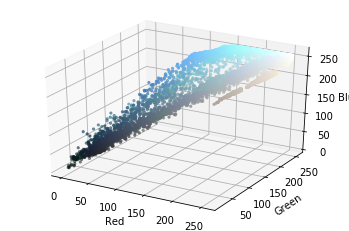

In [259]:
plt.figure()
ax = plt.subplot(1, 1, 1, projection="3d")
ax = get_3d_dist(all_colors,ax)
plt.show()

In [254]:
all_colors.shape

(1, 2780549, 3)